In [19]:
!pip install mlxtend

  Obtaining dependency information for mlxtend from https://files.pythonhosted.org/packages/1c/07/512f6a780239ad6ce06ce2aa7b4067583f5ddcfc7703a964a082c706a070/mlxtend-0.23.1-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   - -------------------------------------- 0.1/1.4 MB 1.6 MB/s eta 0:00:01
   ---- ----------------------------------- 0.2/1.4 MB 2.1 MB/s eta 0:00:01
   ---------- ----------------------------- 0.4/1.4 MB 2.9 MB/s eta 0:00:01
   --------------- ------------------------ 0.6/1.4 MB 3.3 MB/s eta 0:00:01
   ------------------------ --------------- 0.9/1.4 MB 3.9 MB/s eta 0:00:01
   ------------------------------ --------- 1.1/1.4 MB 4.1 MB/s eta 0:00:01
   ---------------------------------- ----- 1.3/1.4 MB 4.4 MB/s eta 0:00:01
   ---------------------------------------  1.4/1.4 MB 4.0 MB/s eta 0:00:01
   ---------------------------------------- 1.4/1.4 MB 3.8 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
# Load libraries
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.model_selection import GridSearchCV # find optimal hyperparameters
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt

In [2]:
# load_data
df = pd.read_csv('mushroom_cleaned.csv')
df.head()

,cap-diameter,cap-shape,gill-attachment,gill-color,stem-height,stem-width,stem-color,season,class
0,1372,2,2,10,3.807467,1545,11,1.804273,1
1,1461,2,2,10,3.807467,1557,11,1.804273,1
2,1371,2,2,10,3.612496,1566,11,1.804273,1
3,1261,6,2,10,3.787572,1566,11,1.804273,1
4,1305,6,2,10,3.711971,1464,11,0.943195,1


In [3]:
#split dataset into features and target variable
X = df.iloc[:, 0:8] 
y = df.iloc[:, -1:]

In [4]:
# split data into train, validation and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle= True, random_state=1)

In [5]:
# spilt train into train data and valid data for comparing different model structures and choosing hyperparameters of the model.
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, shuffle=True, random_state=1)

In [6]:
# 60 : 20 : 20
len(X_train), len(X_valid), len(X_test)

(32421, 10807, 10807)

In [7]:
# build the baseline model
# create decision tree model object 
model = DecisionTreeClassifier()

# train model 
model = model.fit(X_train, y_train)

# predict the response for X_test
y_pred = model.predict(X_valid)

# Evaluate model : accuracy
print("Baseline accuracy:", metrics.accuracy_score(y_valid, y_pred))

Baseline accuracy: 0.9758489867678357


## Optimize performance

In [9]:
# 1. Change criterion: gini(default), entropy, log-loss
model = DecisionTreeClassifier(criterion='entropy')

# train model 
model = model.fit(X_train, y_train)

# predict the response for X_valid
y_pred = model.predict(X_valid)

# Evaluate model : accuracy
print("Accuracy:", metrics.accuracy_score(y_valid, y_pred))

Accuracy: 0.9777921717405386


In [22]:
# 1. Pre pruning 
# + max_depth: int, default = None
# + min_samples_split: int or float, default = 2
# + min_samples_leaf: int or float, default = 1
# should train for 10 - 40 depth tree to see the increase

def decisionTree(crite): 
    acc = []
    for i in range (10, 31): 
        model = DecisionTreeClassifier(criterion= crite, max_depth= i)

        # train model 
        model = model.fit(X_train, y_train)

        # predict the response for X_valid
        y_pred = model.predict(X_valid)

        # Evaluate model : accuracy
        accuracy = metrics.accuracy_score(y_valid, y_pred)
        acc.append(accuracy)
    return acc

entropy = decisionTree('entropy')
gini = decisionTree('gini')
logLoss = decisionTree('log_loss')

In [31]:
max(entropy), max(gini), max(logLoss)


(0.9787174979180161, 0.9769593781808087, 0.9793652262422504)

In [33]:
depthOfMax = logLoss.index(max(logLoss)) + 10
depthOfMax

24

Text(0, 0.5, 'Accuracy')

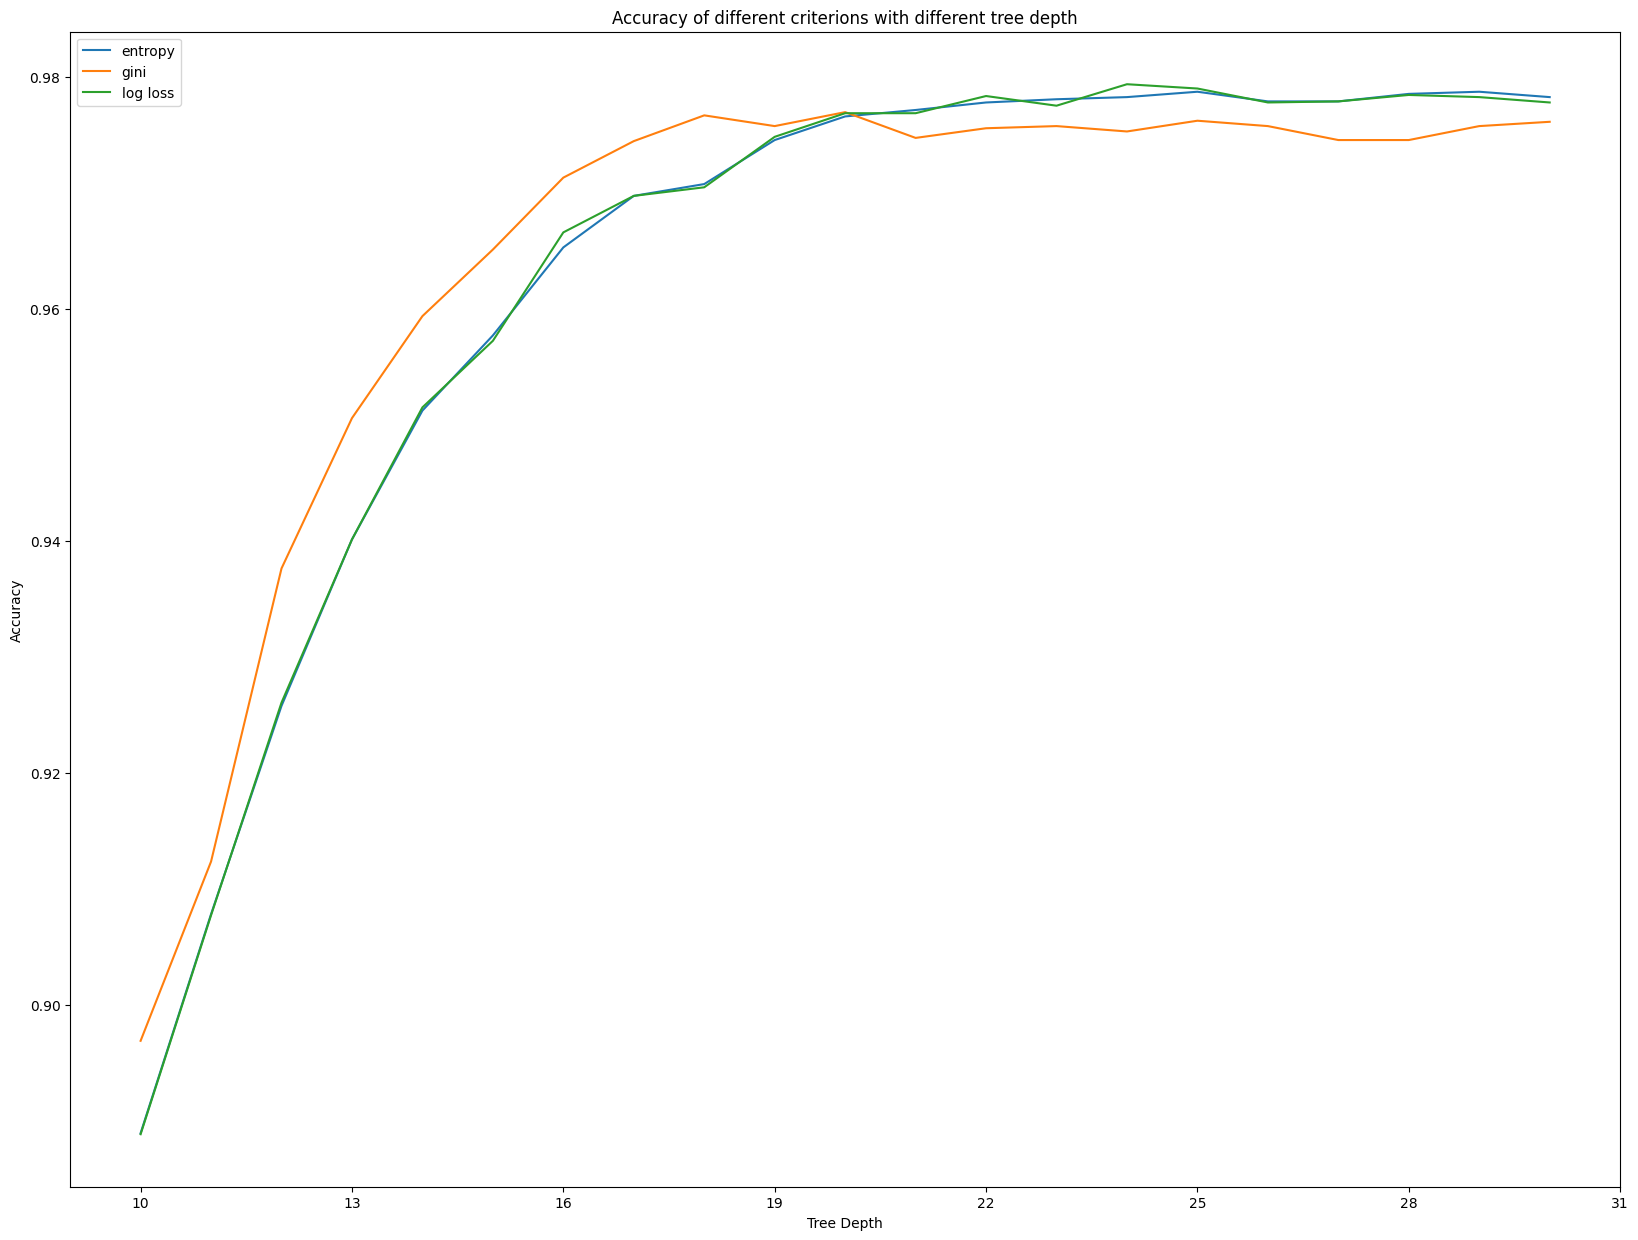

In [25]:
plt.figure(figsize=(20, 15))
plt.plot(entropy, label = 'entropy')
plt.plot(gini, label = 'gini')
plt.plot(logLoss, label = 'log loss')
plt.legend()
plt.title('Accuracy of different criterions with different tree depth')
plt.xticks(ticks=(0, 3, 6, 9, 12, 15, 18, 21), labels=(10, 13, 16, 19, 22, 25, 28, 31))
plt.xlabel("Tree Depth")
plt.ylabel("Accuracy")



In [26]:
# optimal hyperparameters using GridSearchCV
parameter = {
    'criterion' :['entropy','log_loss'],
    'max_depth':[21, 22, 23, 24, 25, 26],
    'min_samples_split' : [1, 2, 3, 4],
    'min_samples_leaf': [1, 2, 3, 4],
}

model = DecisionTreeClassifier()
cv = GridSearchCV(model, param_grid=parameter, cv=5)
cv.fit(X_train, y_train)

c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
240 fits failed out of a total of 960.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
240 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['entropy', 'log_loss'],
                         'max_depth': [21, 22, 23, 24, 25, 26],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [1, 2, 3, 4]})

In [27]:
cv.score(X_valid,y_valid)

0.9770519107985565

In [28]:
cv.best_params_

{'criterion': 'entropy',
 'max_depth': 23,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

# Feature selection

In [8]:
# feature selection 
# 1. Filter method: F value, Variance threshold, mutual information
# 2. Wrapper method: Exhaustive feature selection(EFS), Sequential forward selection (SFS), Sequential backward selection (SBS)
# 3. Embedded method: 

# Scale data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.fit_transform(X_valid)

In [12]:
# Feature selection using filter method
# Get feature importances
importances = model.feature_importances_
 
# Select features with importance greater than a threshold
threshold = 0.1  # Adjust as needed
selected_features = X.columns[importances > threshold]
 
# Use only the selected features
X_train_selected = X_train[selected_features]
X_valid_selected = X_valid[selected_features]

In [14]:
# Train a new model using the selected features
model_selected = DecisionTreeClassifier(criterion='log_loss', max_depth=24)
model_selected.fit(X_train_selected, y_train)
y_pred_selected = model_selected.predict(X_valid_selected)

In [16]:
# Calculate the accuracy of the model with selected features
accuracy_selected_features = metrics.accuracy_score(y_valid, y_pred_selected)
print(f"Accuracy with selected features: {accuracy_selected_features}")

Accuracy with selected features: 0.9511427778291848


In [20]:
# using Exhaustive Features Selection

# Import ExhaustiveFeatureSelector from Mlxtend
import mlxtend
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
model = DecisionTreeClassifier(criterion='log_loss', max_depth=24)

efs = EFS(model,
          min_features = 1,
          max_features = 8,
          scoring = 'accuracy',
          print_progress = True,
          cv = 5)
efs.fit(X_train, y_train)

print('Best Accuracy Score: %.2f' % efs.best_score_)
print('Best subset (indices): ', efs.best_idx_)
print('Best subset (corresponding names): ', efs.best_feature_names_)

Features: 255/255

Best Accuracy Score: 0.97
Best subset (indices):  (0, 1, 2, 3, 4, 5, 6, 7)
Best subset (corresponding names):  ('cap-diameter', 'cap-shape', 'gill-attachment', 'gill-color', 'stem-height', 'stem-width', 'stem-color', 'season')


# Train model with parameter of the best accuracy we get on validation data

In [6]:
len(X_train), len(X_test)

(43228, 10807)

In [7]:

model = DecisionTreeClassifier(criterion='log_loss', max_depth=24)

# train model 
model = model.fit(X_train, y_train)

# predict the response for X_test
y_pred = model.predict(X_test)

# Evaluate model : accuracy
print("Final accuracy for decision tree method:", metrics.accuracy_score(y_test, y_pred))

Final accuracy for decision tree method: 0.9808457481262145


In [ ]:
# 1. Random forest (Bagging): Hien
# 2. Boosting : Hiep
# 3. SVM : Hoan 
# toi thuw 6 
 